In [224]:
#! pip install win32gui

Finding the window. Poker client

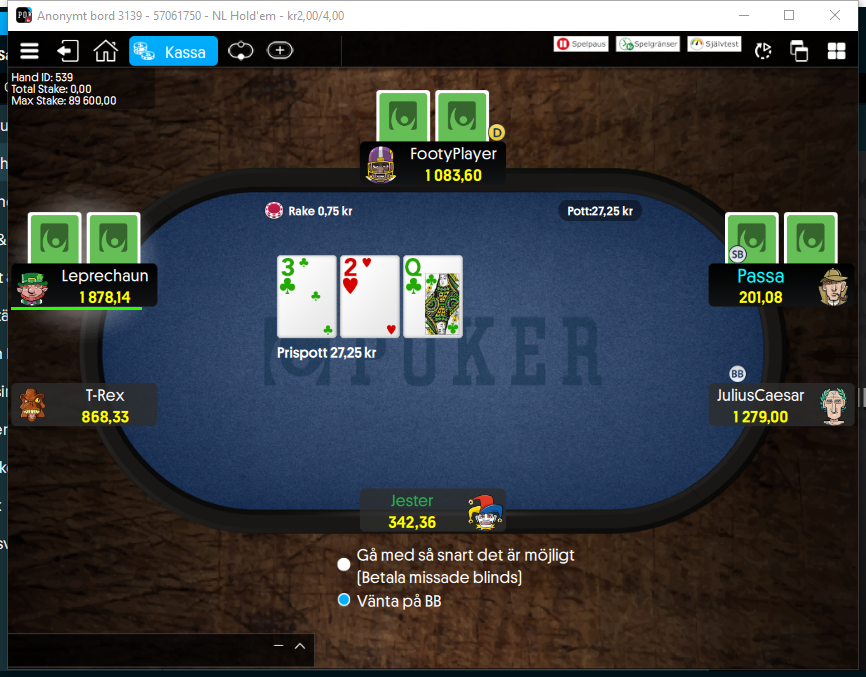

True

In [225]:
import win32gui
from PIL import Image, ImageGrab
import re
# take id from client input
id = input("Enter the ID: ")
# Define a regular expression pattern to match the ID in the window title
id_pattern = r"\b" + id + r"\b"

# Find the window handle of the table by matching on the ID in the title
def find_table_window_handle():
    window_handle = None
    def callback(hwnd, regex):
        title = win32gui.GetWindowText(hwnd)
        if re.search(regex, title):
            nonlocal window_handle
            window_handle = hwnd
    win32gui.EnumWindows(callback, id_pattern)
    return window_handle

# Capture a screenshot of the table window
def capture_table_screenshot():
    window_handle = find_table_window_handle()
    if window_handle:
        screenshot = ImageGrab.grab(win32gui.GetWindowRect(window_handle))
        screenshot.save("table_screenshot.png")
        display(screenshot)
        return True
    else:
        return False

# Call the capture_table_screenshot function to capture the screenshot
capture_table_screenshot()



Identifying seats and cash stacks

In [226]:
#! pip install pytesseract
#! pip install opencv-python

Player boxes: [(717, 265, 825, 306), (403, 142, 548, 185), (9, 383, 159, 426), (361, 491, 512, 538), (50, 263, 201, 317), (709, 381, 854, 429)]


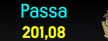

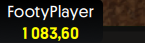

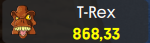

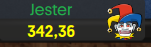

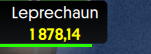

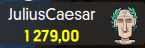

In [227]:
import win32gui
from PIL import Image, ImageGrab, ImageOps
import pytesseract
import re
import cv2
import numpy as np
import os

# Load all player box templates
player_box_templates = []
for png in os.listdir("player_box_templates"):
    if png.endswith(".png"):
        player_box_templates.append(cv2.imread("player_box_templates/" + png, 0))

# Identify the positions of all player boxes in the table screenshot
def identify_player_boxes():
    table_screenshot = cv2.imread("table_screenshot.png", 0)
    player_boxes = []
    for template in player_box_templates:
        w, h = template.shape[::-1]
        res = cv2.matchTemplate(table_screenshot, template, cv2.TM_CCOEFF_NORMED)
        threshold = 0.55
        loc = np.where(res >= threshold)
        for pt in zip(*loc[::-1]):
            player_box = (pt[0], pt[1], pt[0] + w, pt[1] + h)
            if not any([overlap(player_box, pb) for pb in player_boxes]):
                player_boxes.append(player_box)
    return player_boxes


# Check if two rectangles overlap
def overlap(rect1, rect2):
    return not (rect1[2] <= rect2[0] or rect1[0] >= rect2[2] or rect1[3] <= rect2[1] or rect1[1] >= rect2[3])


# Call the capture_table_screenshot, identify_player_boxes, and extract_stack_size functions to identify all player profiles and their respective positions and stack sizes
player_boxes = identify_player_boxes()
print("Player boxes:", player_boxes)

# Save screenshot of each player box
for player_box in player_boxes:
    player_screenshot = Image.open("table_screenshot.png").crop(player_box)
    display(player_screenshot)

From the players. Get the current balance

In [228]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

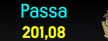

201.08


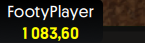

1083.6


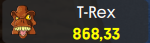

868.33


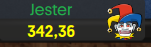

342.36


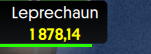

1878.14


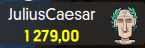

1279.0


In [246]:
import cv2
import numpy as np
from PIL import Image, ImageOps

# Preprocess the player box image to extract the stack size.
# Which is digits that can include a comma for decimal places. The digits (stack size) are at the bottom and in yellow color.
def extract_stack_size(player_box):
    player_screenshot = Image.open("table_screenshot.png").crop(player_box)
    
    # Convert to grayscale
    player_screenshot = ImageOps.grayscale(player_screenshot)

    # hacky library
    stack = pytesseract.image_to_string(player_screenshot, config='--psm 6')
    stack = stack.replace("g", "8")
    stack = stack.replace("-", "")
    try:
        stack = [s for s in stack.split() if re.search(r"^\d+,|.\d+$", s)][0] # ugly af
        stack = stack.replace(",", ".")
        stack = float(stack)
    except:
        stack = "unknown"
    print(stack)

### TEST ####
for player_box in player_boxes:
    player_screenshot = Image.open("table_screenshot.png").crop(player_box)
    display(player_screenshot)
    stack = extract_stack_size(player_box)

Find the dealer button and from there figure out everyones position


In [252]:
import math

def get_positions(dealer, profiles):
    positions = {}

    # Determine the positions of each player relative to the dealer's position
    for profile in profiles:
        dx = profile[0] - dealer[0]
        dy = profile[1] - dealer[1]
        angle = math.atan2(dy, dx)
        positions[angle] = profile

    # Sort the positions by angle relative to the dealer's position
    sorted_positions = sorted(positions.items())

    # Determine the number of players at the table
    num_players = len(profiles)

    if num_players == 2:
        # Heads up
        positions = {'SB': sorted_positions[0][1], 'BB': sorted_positions[1][1]}
    elif num_players == 3:
        # Three handed
        positions = {'SB': sorted_positions[0][1], 'BB': sorted_positions[1][1], 'BTN': sorted_positions[2][1]}
    elif num_players == 4:
        # Four handed
        positions = {'SB': sorted_positions[0][1], 'BB': sorted_positions[1][1], 'UTG': sorted_positions[2][1], 'BTN': sorted_positions[3][1]}
    elif num_players == 5:
        # Five handed
        positions = {'SB': sorted_positions[0][1], 'BB': sorted_positions[1][1], 'UTG': sorted_positions[2][1], 'CO': sorted_positions[3][1], 'BTN': sorted_positions[4][1]}
    elif num_players == 6:
        # Six handed
        positions = {'SB': sorted_positions[0][1], 'BB': sorted_positions[1][1], 'UTG': sorted_positions[2][1], 'MP': sorted_positions[3][1], 'CO': sorted_positions[4][1], 'BTN': sorted_positions[5][1]}
    else:
        # Invalid number of players
        raise ValueError('Invalid number of players')

    return positions

def find_dealer():
    table_screenshot = cv2.imread("table_screenshot.png", 0)
    dealer_template = cv2.imread("dealer_template.png", 0)
    w, h = dealer_template.shape[::-1]
    res = cv2.matchTemplate(table_screenshot, dealer_template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.55
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):
        dealer_box = (pt[0], pt[1], pt[0] + w, pt[1] + h)
        return dealer_box
    
dealer_box = find_dealer()
positions = get_positions(dealer_box, player_boxes)

display(Image.open("table_screenshot.png"))
for position in positions:
    print(position)
    display(Image.open("table_screenshot.png").crop(positions[position]))




SB (717, 265, 825, 306)
BB (403, 142, 548, 185)
UTG (709, 381, 854, 429)
MP (361, 491, 512, 538)
CO (9, 383, 159, 426)
BTN (50, 263, 201, 317)
